<a href="https://colab.research.google.com/github/AriannaHeartbell/sd-llm_example/blob/main/kohya_ss_VAE_latents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title 1. 라이브러리 설치
# 'diffusers', 'transformers', 'safetensors' 라이브러리를 설치합니다.
!pip install diffusers transformers safetensors --quiet

print("✅ 라이브러리 설치가 완료되었습니다.")

✅ 라이브러리 설치가 완료되었습니다.


In [2]:
#@title 2. NPZ 이미지 뷰어 (최종 안정화 버전) { display-mode: "form" }

#@markdown ---
#@markdown ### 1. VAE 모델 설정
#@markdown VAE 모델 파일의 URL을 입력하세요. SDXL 기본 VAE가 기본값으로 설정되어 있습니다.
vae_url = "https://huggingface.co/stabilityai/sdxl-vae/resolve/main/sdxl_vae.safetensors" #@param {type:"string"}

#@markdown ---
#@markdown ### 2. NPZ 파일 제공 방식 선택
#@markdown `.npz` 파일을 어떻게 제공할지 선택하세요.
#@markdown - **UPLOAD**: 로컬 PC에서 직접 파일을 업로드합니다. (간단한 테스트에 추천)
#@markdown - **GOOGLE_DRIVE**: 구글 드라이브에 있는 파일 경로를 사용합니다. (여러 파일 확인 시 편리)
npz_upload_method = "UPLOAD" #@param ["UPLOAD", "GOOGLE_DRIVE"]

#@markdown ---
#@markdown ### 3. (구글 드라이브 사용 시) NPZ 파일 경로
#@markdown `npz_upload_method`를 `GOOGLE_DRIVE`로 선택한 경우에만 아래 경로를 입력하세요.
#@markdown 예시: `/content/drive/MyDrive/dataset/my_image.npz`
npz_drive_path = "" #@param {type:"string"}

NPZ 파일 경로: ComfyUI_T2i_face_00186__1536x0896_sdxl.npz
VAE 모델 로드 중...
VAE가 cuda에 로드되었습니다. (정밀도: float32)

NPZ 파일 로드 및 이미지 복원을 시작합니다...

--- 🖼️ 이미지 복원 완료 ---


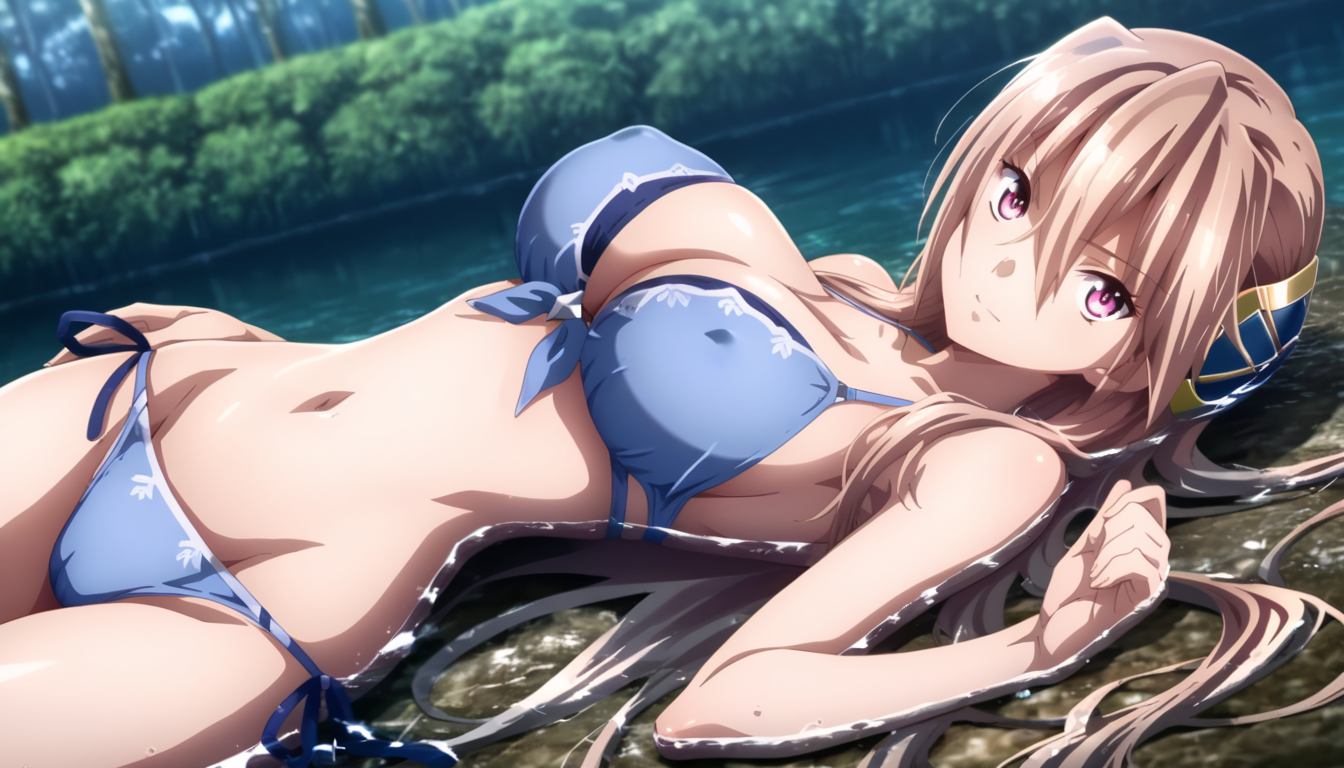

In [9]:
#@title 3. NPZ 파일 -> 이미지로 복원 (상태 초기화 문제 해결 버전)

import torch
import numpy as np
import requests
import os
from PIL import Image
from diffusers import AutoencoderKL
from google.colab import files, drive
from IPython.display import display, clear_output

# --- 1. NPZ 파일 준비 ---
npz_file_path = None
try:
    # ★★★★★ 문제의 원인이자 해결책 ★★★★★
    # Colab 세션에 남아있는 이전 업로드 정보를 무시하고,
    # 디코딩을 할 때는 항상 새로 NPZ 파일을 업로드하도록 강제합니다.
    print("PC에서 복원할 NPZ 파일을 업로드 해주세요...")
    uploaded = files.upload()
    if not uploaded:
        raise Exception("파일이 업로드되지 않았습니다. 셀을 다시 실행해주세요.")

    npz_file_path = list(uploaded.keys())[0]
    clear_output() # 업로드 완료 후 출력 메시지 정리

except Exception as e:
    print(f"NPZ 파일 준비 중 오류: {e}")
    # 오류 발생 시에도 실행이 멈추도록 예외를 다시 발생시킴
    if 'npz_file_path' not in locals() or not npz_file_path:
        raise e

print(f"NPZ 파일 경로: {npz_file_path}")

# --- 2. VAE 모델 다운로드 및 로드 ---
vae_local_path = "vae.safetensors"
if not os.path.exists(vae_local_path):
    print(f"VAE 모델 다운로드 중... (URL: {vae_url})")
    with requests.get(vae_url, stream=True) as r:
        r.raise_for_status()
        with open(vae_local_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

print("VAE 모델 로드 중...")
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = AutoencoderKL.from_single_file(vae_local_path, torch_dtype=torch.float32).to(device)
print(f"VAE가 {device}에 로드되었습니다. (정밀도: float32)")

# --- 3. NPZ 데이터 로드 및 이미지 복원 ---
def restore_image_from_npz(vae_model, npz_data, device):

    if 'latents' not in npz_data:
        raise KeyError("NPZ 파일에 'latents' 키가 없습니다. 파일 내용을 확인해주세요.")

    latents = torch.from_numpy(npz_data['latents'])

    if latents.dim() == 3:
        latents = latents.unsqueeze(0)

    latents = latents.to(device, dtype=torch.float32)

    with torch.no_grad():
        image_tensor = vae_model.decode(latents).sample

    image_tensor = (image_tensor / 2 + 0.5).clamp(0, 1)
    image_np = image_tensor.detach().cpu().permute(0, 2, 3, 1).numpy()
    image_np = np.nan_to_num(image_np)
    image_np = (image_np * 255).round().astype("uint8")
    pil_image = Image.fromarray(image_np[0])

    return pil_image

print("\nNPZ 파일 로드 및 이미지 복원을 시작합니다...")
try:
    # allow_pickle=True 추가하여 잠재적인 npz 로드 오류 방지
    npz_data = np.load(npz_file_path, allow_pickle=True)
    restored_image = restore_image_from_npz(vae, npz_data, device)

    print("\n--- 🖼️ 이미지 복원 완료 ---")

    display(restored_image)

except Exception as e:
    print(f"\n❌ 오류 발생: {e}")

In [41]:
#@title 4. 이미지 -> NPZ 인코딩 (kohya_ss 호환 최종 버전)

import torch
import numpy as np
import requests
import os
from PIL import Image
from diffusers import AutoencoderKL
from google.colab import files
from torchvision import transforms
import io

try:
    # --- 1. VAE 모델 준비 ---
    print("--- 1. VAE 모델 준비 시작 ---")
    vae_url = "https://huggingface.co/stabilityai/sdxl-vae/resolve/main/sdxl_vae.safetensors"
    vae_local_path = "vae.safetensors"

    if not os.path.exists(vae_local_path):
        print(f"VAE 모델 다운로드 중...")
        with requests.get(vae_url, stream=True) as r:
            r.raise_for_status()
            with open(vae_local_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

    print("VAE 모델 로드 중...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    vae = AutoencoderKL.from_single_file(vae_local_path, torch_dtype=torch.float32).to(device)
    print(f"VAE가 {device}에 로드되었습니다. (정밀도: float32)")

    # --- 2. 이미지 업로드 ---
    print("\n--- 2. 이미지 업로드 시작 ---")
    print("NPZ로 변환할 이미지를 업로드 해주세요...")
    uploaded = files.upload()
    if not uploaded:
        raise Exception("파일이 업로드되지 않았습니다.")

    file_name = next(iter(uploaded))
    image_data = uploaded[file_name]
    print(f"'{file_name}' 파일 처리 시작.")

    # --- 3. 이미지 전처리 ---
    print("\n--- 3. 이미지 전처리 시작 ---")
    input_image = Image.open(io.BytesIO(image_data)).convert("RGB")
    preprocess = transforms.Compose(
        [
            transforms.Resize(1024, interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.CenterCrop(1024),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )
    image_tensor = preprocess(input_image).unsqueeze(0).to(device, dtype=torch.float32)

    # --- 4. VAE로 인코딩 ---
    print("\n--- 4. VAE 인코딩 시작 ---")
    with torch.no_grad():
        latent_dist = vae.encode(image_tensor).latent_dist
        latents = latent_dist.sample()

    print("VAE 인코딩 및 스케일링 완료.")

    # --- 5. NPZ 파일로 저장 ---
    print("\n--- 5. NPZ 파일 저장 시작 ---")
    latents_np = latents.detach().cpu().numpy().astype(np.float16)
    output_npz_filename = os.path.splitext(file_name)[0] + "_kohya_compatible.npz"
    np.savez(output_npz_filename, latents=latents_np)
    print(f"✅ 성공! '{output_npz_filename}' 파일이 Colab 환경에 저장되었습니다.")

    # --- 6. 파일 다운로드 ---
    print("\n--- 6. 파일 다운로드 시작 ---")
    files.download(output_npz_filename)
    print("다운로드 명령이 전송되었습니다.")

except Exception as e:
    print(f"\n❌ 오류 발생: {e}")

--- 1. VAE 모델 준비 시작 ---
VAE 모델 로드 중...
VAE가 cuda에 로드되었습니다. (정밀도: float32)

--- 2. 이미지 업로드 시작 ---
NPZ로 변환할 이미지를 업로드 해주세요...


Saving b9ffff08-8624-4ecf-804e-5075d6fb24c1 (1).png to b9ffff08-8624-4ecf-804e-5075d6fb24c1 (1) (1).png
'b9ffff08-8624-4ecf-804e-5075d6fb24c1 (1) (1).png' 파일 처리 시작.

--- 3. 이미지 전처리 시작 ---

--- 4. VAE 인코딩 시작 ---
VAE 인코딩 및 스케일링 완료.

--- 5. NPZ 파일 저장 시작 ---
✅ 성공! 'b9ffff08-8624-4ecf-804e-5075d6fb24c1 (1) (1)_kohya_compatible.npz' 파일이 Colab 환경에 저장되었습니다.

--- 6. 파일 다운로드 시작 ---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

다운로드 명령이 전송되었습니다.


In [10]:
#@title 5. 참조: kohya ss npz 파일 구조

import numpy as np
import torch
from google.colab import files
import io

# 사용자로부터 파일 업로드를 받습니다.
print("분석할 .npz 파일을 업로드해주세요.")
uploaded = files.upload()

# 업로드된 파일이 있는지 확인합니다.
if not uploaded:
    print("\n파일이 업로드되지 않았습니다. 코드를 다시 실행해주세요.")
else:
    # 업로드된 파일의 이름을 가져옵니다. (보통 첫 번째 파일)
    npz_file_name = next(iter(uploaded))

    # 파일 확장자가 .npz 인지 간단히 확인합니다.
    if not npz_file_name.lower().endswith('.npz'):
        print(f"\n오류: 업로드된 파일 '{npz_file_name}'이(가) .npz 파일이 아닌 것 같습니다.")
    else:
        print(f"\n'{npz_file_name}' 파일을 분석합니다...")

        try:
            # 업로드된 파일 데이터(bytes)를 메모리 상에서 바로 읽을 수 있도록 io.BytesIO를 사용합니다.
            npz_file_data = io.BytesIO(uploaded[npz_file_name])

            # NumPy를 사용하여 메모리 상의 npz 파일을 불러옵니다.
            data = np.load(npz_file_data)

            # 파일 내에 어떤 데이터(배열)들이 있는지 확인합니다. (키 목록 출력)
            print(f"\n'{npz_file_name}' 파일에 포함된 데이터 키:")
            print(data.files)

            # 각 키에 해당하는 데이터의 정보를 출력합니다.
            for key in data.files:
                # NumPy 배열을 PyTorch 텐서로 변환합니다.
                tensor = torch.from_numpy(data[key])

                print(f"\n--- 키: '{key}' ---")
                print(f"  - 데이터 타입: {tensor.dtype}")
                print(f"  - 텐서의 차원 (Shape): {tensor.shape}")

                # 실제 데이터의 일부를 보고 싶다면 아래 주석을 해제하세요.
                # print(f"  - 데이터 일부:\n{tensor}")

        except Exception as e:
            print(f"파일을 읽는 중 오류가 발생했습니다: {e}")

분석할 .npz 파일을 업로드해주세요.


Saving ComfyUI_T2i_face_00186__1536x0896_sdxl.npz to ComfyUI_T2i_face_00186__1536x0896_sdxl (1).npz

'ComfyUI_T2i_face_00186__1536x0896_sdxl (1).npz' 파일을 분석합니다...

'ComfyUI_T2i_face_00186__1536x0896_sdxl (1).npz' 파일에 포함된 데이터 키:
['latents', 'original_size', 'crop_ltrb']

--- 키: 'latents' ---
  - 데이터 타입: torch.float32
  - 텐서의 차원 (Shape): torch.Size([4, 96, 168])

--- 키: 'original_size' ---
  - 데이터 타입: torch.int64
  - 텐서의 차원 (Shape): torch.Size([2])

--- 키: 'crop_ltrb' ---
  - 데이터 타입: torch.float64
  - 텐서의 차원 (Shape): torch.Size([4])
